**420-A52-SF - Algorithmes d'apprentissage supervisé - Hiver 2021 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2021 Mikaël Swawola
<br/>
![Travaux Pratiques - Évaluation des modèles de classification](static/14-tp-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif la mise en oeuvre des différentes techniques d'évaluation des modèles de classifications sur des données débalancées

In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### 1 - Simulation de données

In [29]:
# !pip install imblearn
from sklearn.datasets import make_moons
from imblearn.datasets import make_imbalance

In [30]:
N = 10000
ratio_debalancement = 0.01

X_raw, y_raw = make_moons(n_samples=10*N, shuffle=True, noise=0.3, random_state=2020)
X, y =  make_imbalance(X_raw, y_raw, sampling_strategy={0: int(N*(1-ratio_debalancement)), 1: int(N*(ratio_debalancement))})

#### Affichage du jeu de données simulé (classes balancées)

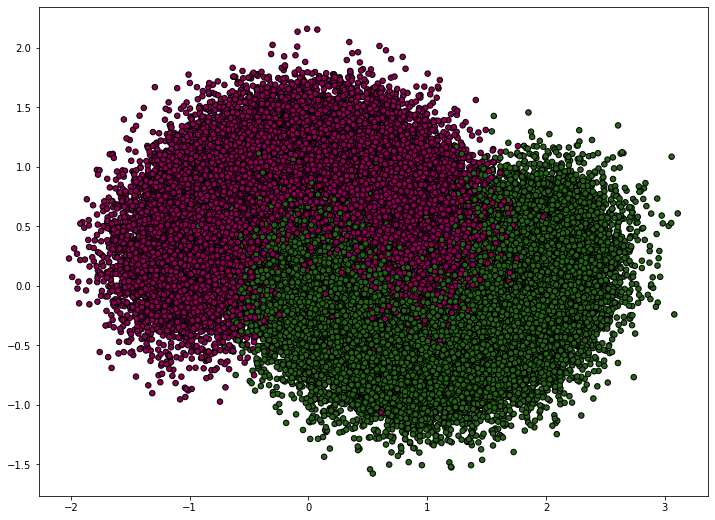

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X_raw[:, 0], X_raw[:, 1], c=y_raw, cmap='PiYG', edgecolor='k', s=30)
plt.show()

#### Affichage du jeu de données simulé (classes fortement débalancées)

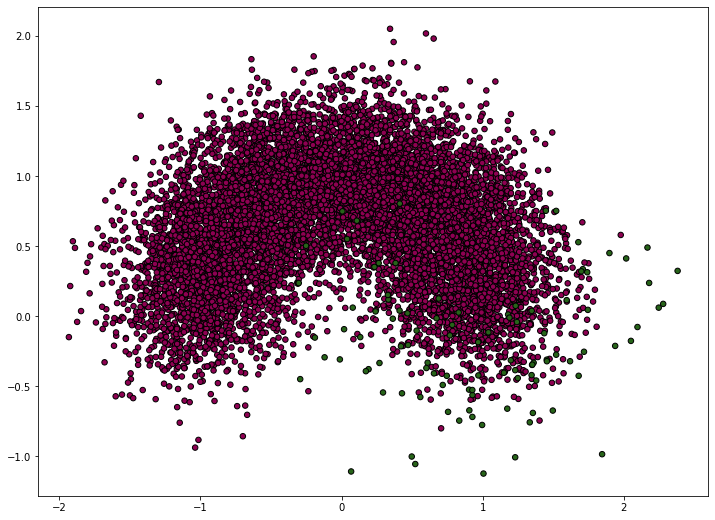

In [32]:
fig = plt.figure(1, figsize=(12, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='PiYG', edgecolor='k', s=30)
plt.show()

### 2 - Préparation de données

<strong>
Séparation des données en train (40%), validation (30%) et test (30%)
</strong>

In [33]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.42857)#, stratify=y_)

In [34]:
import numpy as np

print('Classe négative')
print(f'Train {len(y_train) - np.sum(y_train)}') 
print(f'Val {len(y_val) - np.sum(y_val)}')
print(f'Test {len(y_test) - np.sum(y_test)}')

print('\nClasse positive')
print(f'Train {np.sum(y_train)}') 
print(f'Val {np.sum(y_val)}')
print(f'Test {np.sum(y_test)}')

Classe négative
Train 3959
Val 2971
Test 2970

Classe positive
Train 41
Val 29
Test 30


### 3 - Modèle de référence (baseline)

#### Création d'un modèle baseline et calcul de sa précision (accuracy)

In [35]:
from sklearn.dummy import DummyClassifier

baseline_clf = DummyClassifier(strategy='most_frequent') 
baseline_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [36]:
from sklearn.metrics import accuracy_score

y_pred_train = baseline_clf.predict(X_train)
acc_baseline = accuracy_score(y_pred_train, y_train)
print(f'Performance du modèle de référence (dummy): {100*acc_baseline}%')

Performance du modèle de référence (dummy): 98.97500000000001%


### 4 - Entraînement d'un classificateur (régression logistique, ordre 3)

#### Entraînement du modèle et choix du paramètre de régularisation

In [40]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X_train)

logreg = LogisticRegression(C=0.1).fit(X_poly, y_train)

#### Affichage de la frontière de décision

([], [])

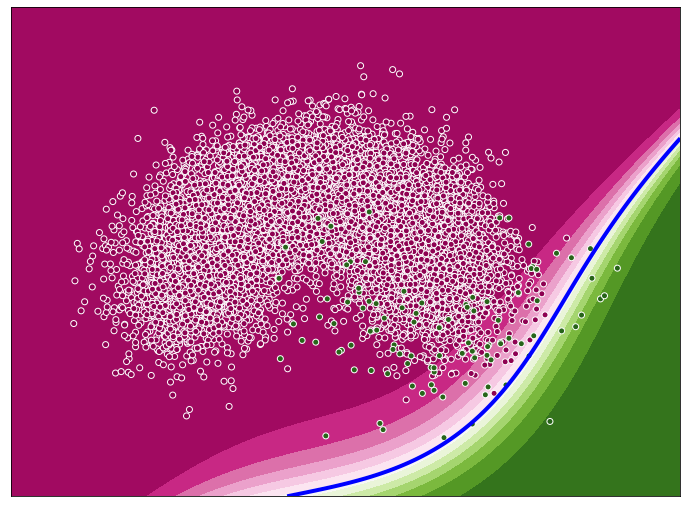

In [41]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .01  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

CC = np.c_[xx.ravel(), yy.ravel()]
Z = logreg.predict_proba(poly.fit_transform(CC))[:,1].reshape(xx.shape)

fig = plt.figure(2, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [0.5], colors=["b"], linewidths=[4])

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='w', cmap='PiYG', linewidth=1)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

### 5 - Matrice de confusion sur l'ensemble de validation

#### Affichage de la matrice de confusion pour un seuil de classification rigide de 0.5. Utiliser le fichiers helpers.py

Confusion matrix, without normalization


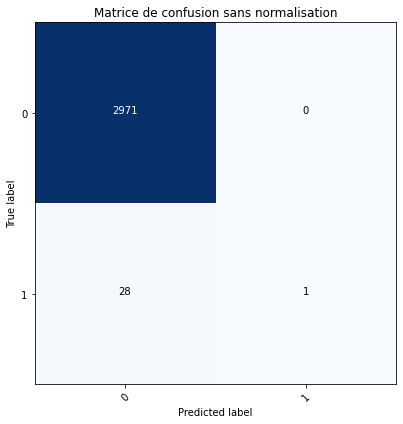

In [42]:
from sklearn.metrics import confusion_matrix
from helpers import plot_confusion_matrix

threshold = 0.5

y_val_pred_proba = logreg.predict_proba(poly.fit_transform(X_val))[:,1]
y_val_pred_label = y_val_pred_proba > threshold

fig = plt.figure(3, figsize=(6, 6))

cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'], title='Matrice de confusion sans normalisation')

#### Calcul de la précision sur l'ensemble de validation

In [43]:
accuracy_score(y_val, y_val_pred_label)

0.9906666666666667

### 6 - Courbe ROC et l'AUC

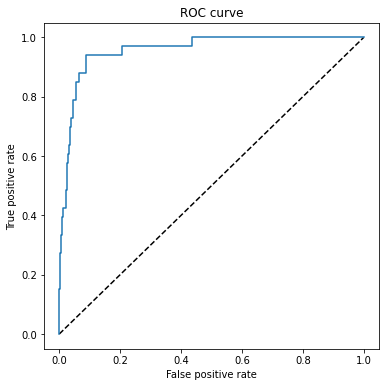

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_rf, tpr_rf, thresholds = roc_curve(y_val, y_val_pred_proba)

fig = plt.figure(4, figsize=(6, 6))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### Calcul de la précision sur l'ensemble de validation

In [21]:
roc_auc_score(y_val, y_val_pred_proba)

0.9570936871240208

#### Sélection de la meilleur valeur du seuil

In [22]:
selected_threshold = thresholds[np.argmax(-fpr_rf + tpr_rf)]
selected_threshold

0.019094021568187892

([], [])

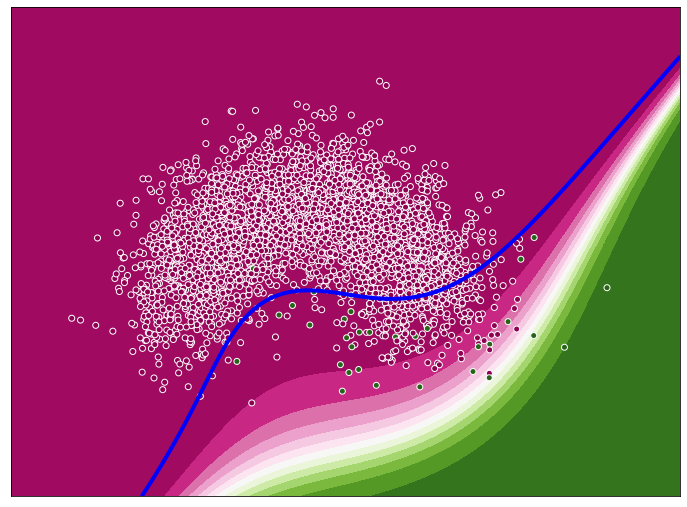

In [23]:
fig = plt.figure(5, figsize=(12, 9))

plt.contourf(xx, yy, Z, cmap="PiYG", levels=15)
plt.contour(xx, yy, Z, [selected_threshold], colors=["b"], linewidths=[4])

plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, edgecolors='w', cmap='PiYG', linewidth=1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

In [ ]:
y_val_pred_label = y_val_pred_proba > selected_threshold

fig = plt.figure(6, figsize=(6, 6))
cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'], title='Matrice de confusion sans normalisation')

### 7 -  Calculer la courbe de précision/rappel

#### Affichage de la courbe de précision et rappel

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

fig = plt.figure(7, figsize=(6, 6))

plt.plot(recall, precision, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')

### 8 - Évaluer le F-score pour différents seuils

#### Sélection d'une valeur de beta et calcul du F-score pour différentes valeurs du seuil

In [ ]:
from sklearn.metrics import fbeta_score

beta = 4

M = 1000
thresholds = np.linspace(-0.1, 1.1, M)
score = np.zeros(shape=(M,))
for i in range(0,len(thresholds)):
    y_pred_ = (y_val_pred_proba > thresholds[i])*1.0
    score[i] = fbeta_score(y_val, y_pred_, beta=beta)
    
fig = plt.figure(8, figsize=(6, 6))

plt.plot(thresholds, score)
plt.xlabel('Threshold')
plt.ylabel('F-score')
plt.title('F-score')
plt.show()

In [ ]:
selected_threshold = thresholds[np.argmax(score)]
selected_threshold

In [ ]:
y_val_pred_label = y_val_pred_proba > selected_threshold

fig = plt.figure(6, figsize=(6, 6))
cnf_matrix = confusion_matrix(y_val, y_val_pred_label)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

### 9 - Calcul de la métrique d'entropie croisée

#### Calcul de l'entropie croiseé (ou log loss)

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
log_loss(y_val, y_val_pred_proba)

### 10 - Calcul de la métrique d'utilité

#### Calcul de la matrice d'utilité correspondant à la matrice de confusion précédente et avec les coûts suivants

FP: -0
FN: -0
TP: 1
TN: 1

In [ ]:
FP_loss = -100
FN_loss = -1000
TP_reward = 100
TN_reward = 0

utility = lambda cnf_matrix: cnf_matrix[1,1]*TP_reward + cnf_matrix[0,0]*TN_reward + cnf_matrix[1,0]*FN_loss + cnf_matrix[0,1]*FP_loss

In [ ]:
M = 100
thresholds = np.linspace(-0.1, 1.1, M)
score = np.zeros(shape=(M,))
for i in range(0,len(thresholds)):
    y_pred_ = (y_val_pred_label > thresholds[i])*1.0
    cnf_matrix = confusion_matrix(y_val, y_pred_)
    score[i] = utility(cnf_matrix)

In [ ]:
f = plt.figure(4541)
plt.grid(True)
plt.ion()
plt.yscale('symlog')
plt.plot(thresholds, score)
plt.xlabel('Threshold')
plt.ylabel('utility')
plt.title('Utility-based cost')

In [ ]:
thresholds[np.argmax(score)]

### Fin de l'atelier